In [80]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit

In [104]:
dataset = pd.read_csv('1D_HiLo.csv', index_col='Data')

def label_trend(row):
    if row['Abertura'] > row['Fechamento']:
        return 0
    elif row['Abertura'] <= row['Fechamento']:
        return 1
    
dataset['Trend'] = dataset.apply(lambda row: label_trend(row), axis=1)

dataset = dataset.dropna()
dataset.head

<bound method NDFrame.head of                   Abertura   Maxima   Minima  Fechamento   VWAP D  Trend
Data                                                                    
21/09/2022 13:05   5458.40  5460.50  5457.35     5457.87  5436.65      0
21/09/2022 13:10   5458.40  5458.40  5454.19     5454.19  5436.79      0
21/09/2022 13:15   5455.24  5458.92  5453.67     5457.35  5436.88      1
21/09/2022 13:20   5458.40  5458.40  5455.77     5456.29  5437.05      0
21/09/2022 13:25   5456.82  5457.35  5455.77     5456.29  5437.06      0
...                    ...      ...      ...         ...      ...    ...
15/06/2023 11:45   4834.50  4836.00  4831.50     4832.50  4837.38      0
15/06/2023 11:50   4832.00  4834.50  4831.00     4833.50  4837.33      1
15/06/2023 11:55   4833.50  4834.00  4829.00     4831.00  4837.15      0
15/06/2023 12:00   4831.00  4831.50  4827.00     4827.50  4836.96      0
15/06/2023 12:05   4827.00  4832.00  4826.50     4831.00  4836.89      1

[20001 rows x 6 colu

In [ ]:
target_y = dataset['Fechamento']
x_feat = dataset.iloc[:,0:4]

sc = MinMaxScaler().fit(x_feat.values)
x_ft = sc.transform(x_feat.values)
x_ft = pd.DataFrame(columns=x_feat.columns, data=x_ft, index=x_feat.index)

values_ft = sc.fit_transform(dataset.values)
dataset_ft = pd.DataFrame(columns=dataset.columns, data=values_ft, index=dataset.index)
dataset_ft = x_ft.join(target_y)
dataset_ft

In [93]:
def lstm_split(data, n_steps):
    x, y = [], []
    for i in range(len(data)-(n_steps+1)):
        x.append(data[i:i + n_steps, :-1])
        y.append(int(data[i + (n_steps-1), -1]))
    
    return np.array(x), np.array(y)

In [116]:
x1, y1 = lstm_split(dataset.values, n_steps=2)

train_split = 0.8
split_idx = int(np.ceil(len(x1)*train_split))
date_index = dataset_ft.index

x_train, x_test = x1[:split_idx], x1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]

x_train_date, x_test_date = date_index[:split_idx], date_index[split_idx:]

print(x1.shape, x_train.shape, x_test.shape, y_test.shape)

(19998, 2, 5) (15999, 2, 5) (3999, 2, 5) (3999,)


In [117]:
tf.keras.backend.clear_session()
lstm = Sequential()
#lstm.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
lstm.add(Conv1D(input_shape=(x_train.shape[1], x_train.shape[2]) ,filters=32, kernel_size=3, padding='same', activation='relu'))
lstm.add(MaxPooling1D(pool_size=2))
lstm.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 32)            0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 17,163
Trainable params: 17,163
Non-trainable params: 0
_________________________________________________________________


In [119]:
history = lstm.fit(x_train, y_train, epochs=20, batch_size=4, shuffle=False)

Epoch 1/20
4000/4000 [==============================] - 6s 2ms/step - loss: 0.6968 - accuracy: 0.5230
Epoch 2/20
4000/4000 [==============================] - 6s 2ms/step - loss: 0.6916 - accuracy: 0.5282
Epoch 3/20
4000/4000 [==============================] - 6s 1ms/step - loss: 0.6930 - accuracy: 0.5250
Epoch 4/20
4000/4000 [==============================] - 6s 1ms/step - loss: 0.6921 - accuracy: 0.5253
Epoch 5/20
4000/4000 [==============================] - 6s 2ms/step - loss: 0.6917 - accuracy: 0.5313
Epoch 6/20
4000/4000 [==============================] - 6s 2ms/step - loss: 0.6920 - accuracy: 0.5297
Epoch 7/20
4000/4000 [==============================] - 7s 2ms/step - loss: 0.6920 - accuracy: 0.5292
Epoch 8/20
4000/4000 [==============================] - 7s 2ms/step - loss: 0.6915 - accuracy: 0.5307
Epoch 9/20
4000/4000 [==============================] - 7s 2ms/step - loss: 0.6915 - accuracy: 0.5283
Epoch 10/20
4000/4000 [==============================] - 7s 2ms/step - loss: 0.691

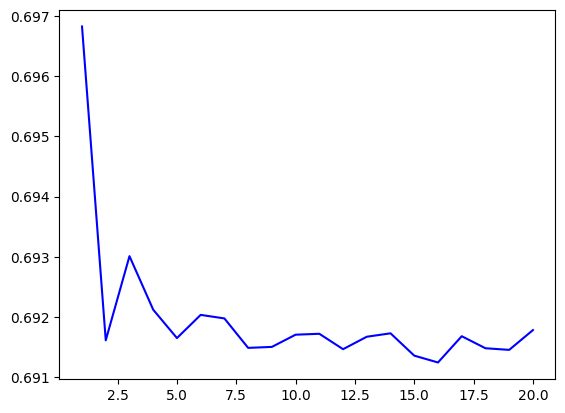

In [120]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.show()


In [121]:
scores = lstm.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 53.71%


125/125 [==============================] - 0s 1ms/step
Mean Squared Error:  25.37881431495757
Mean Absolute Percentage Error:  0.0046415596047385665
Mean Absolute Error:  24.10156259279663


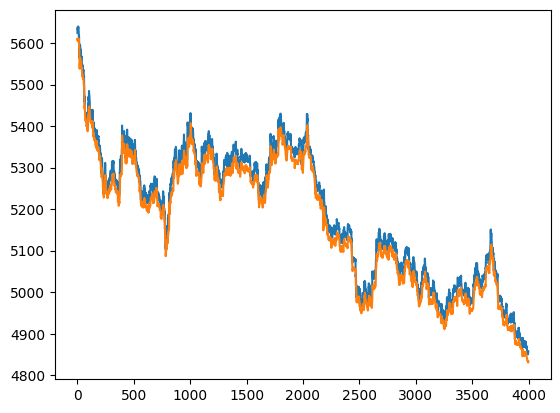

In [205]:
   
y_pred = lstm.predict(x_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('Mean Squared Error: ', rmse)
print('Mean Absolute Percentage Error: ', mape)
print('Mean Absolute Error: ', mae)

plt.plot(y_test)
plt.plot(y_pred)
plt.show()

In [208]:
candles = [[[4812.5, 4820.5, 4811.5, 4857.17], [4819, 4819.5, 4816.5, 4856.8]]]
#print(x1)

y_pred = lstm.predict(candles)

1/1 [==============================] - 0s 39ms/step


In [209]:
print(y_pred)

[[4801.223]]
